In [2]:
%matplotlib inline

# Text Clustering

Some popular clustering algorithms are briefly described as follows:

- *Hierarchical clustering models*: These clustering models are also known as *connectivity-based clustering methods* and are based on the concept that similar objects will be closer to related objects in the vector space than unrelated objects, which will be farther away from them. Clusters are formed by connecting objects based on their distance and they can be visualized using a *dendrogram*. The output of these models is a complete, exhaustive hierarchy of clusters. They are mainly subdivided into agglomerative and divisive clustering models.
- *Centroid-based clustering models*: These models build clusters in such a way that each cluster has a central representative member that represents each cluster and has the features that distinguish that particular cluster from the rest. There are various algorithms in this, like k-means, k-medoids, and so on, where we need to set the number of clusters 'k' in advance, and distance metrics like squares of distances from each data point to the centroid need to be minimized. The disadvantage of these models is that you need to specify the 'k' number of clusters in advance, which may lead to local minima, and you may not get a true clustered representation of your data.
- *Distribution-based clustering models*: These models make use of concepts from probability distributions when clustering data points. The idea is that objects having similar distributions can be clustered into the same group or cluster. *Gaussian mixture models* (GMM) use algorithms like the Expectation-Maximization algorithm for building these clusters. Feature and attribute correlations and dependencies can also be captured using these models, but it is prone to overfitting.
- *Density-based clustering models*: These clustering models generate clusters from data points that are grouped together at areas of high density compared to the rest of the data points, which may occur randomly across the vector space in sparsely populated areas. These sparse areas are treated as noise and are used as border points to separate clusters. Two popular algorithms in this area include DBSCAN and OPTICS.


Covers :
    
- K-means clustering
- Affinity propagation
- Ward’s agglomerative hierarchical clustering

# Clustering Greatest Movies of All Time


In [1]:
import pandas as pd
import numpy as np

movie_data = pd.read_csv('movie_data.csv')

print (movie_data.head())

movie_titles = movie_data['Title'].tolist()
movie_synopses = movie_data['Synopsis'].tolist()

print ('Movie:', movie_titles[0])
print ('Movie Synopsis:', movie_synopses[0][:1000])


from normalization import normalize_corpus
from utils import build_feature_matrix

# normalize corpus
norm_movie_synopses = normalize_corpus(movie_synopses,
                                       lemmatize=True,
                                       only_text_chars=True)

# extract tf-idf features
vectorizer, feature_matrix = build_feature_matrix(norm_movie_synopses,
                                                  feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85,
                                                  ngram_range=(1, 2))
# view number of features
print (feature_matrix.shape)

# get feature names
feature_names = vectorizer.get_feature_names()

# print sample features
print (feature_names[:20])

                      Title                                           Synopsis
0             The Godfather  In late summer 1945, guests are gathered for t...
1  The Shawshank Redemption  In 1947, Andy Dufresne (Tim Robbins), a banker...
2          Schindler's List  The relocation of Polish Jews from surrounding...
3               Raging Bull  The film opens in 1964, where an older and fat...
4                Casablanca  In the early years of World War II, December 1...
Movie: The Godfather
Movie Synopsis: In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks 

# K-MEANS CLUSTERING

$$ \min {\displaystyle \sum_{i=1}^K}{\displaystyle \sum_{x_n\ \in\ {C}_i}}\left|\right|{x}_n - {\mu}_i\left|\right|{}^2 $$

<br/>

Lloyd’s algorithm is a solution to this problem, which is an iterative procedure consisting of the following steps.

1. Choose initial *k* centroids *μ* *k* by taking *k* random samples from the dataset *X*.

2. Update clusters by assigning each data point or sample to its nearest centroid point. Mathematically, we can represent this as ![$$ {C}_k=\left\{{x}_n\ :\ \left|\right|{x}_n - {\mu}_k\left|\right|\ \le all\left|\right|{x}_n - {\mu}_l\left|\right|\right\} $$](https://learning.oreilly.com/library/view/text-analytics-with/9781484223871/A427287_1_En_6_Chapter_IEq17.gif) where *C* *k* denotes the clusters.

3. Recalculate and update clusters based on the new cluster data points for each cluster obtained from step 2. <br/> Mathematically, this can be represented as ![$$ {\mu}_k = \frac{1}{C_k}\ {\displaystyle \sum_{x_n\ \in\ {C}_k}}{x}_n $$](https://learning.oreilly.com/library/view/text-analytics-with/9781484223871/A427287_1_En_6_Chapter_IEq18.gif)

   where *μ* *k* denotes the centroids.

In [2]:
                
from sklearn.cluster import KMeans

def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

num_clusters = 5    
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters

In [3]:
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print (c.items())

dict_items([(3, 17), (1, 43), (0, 24), (4, 5), (2, 11)])


In [4]:
def get_cluster_data(clustering_obj, movie_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details

In [5]:
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print ('Cluster {} details:'.format(cluster_num))
        print ('-'*20)
        print ('Key features:', cluster_details['key_features'])
        print ('Movies in this cluster:')
        print (', '.join(cluster_details['movies']))
        print ('='*40)

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'title': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show() 

In [7]:
# get clustering analysis data
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)      

In [8]:
# print clustering analysis results
print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ['army', 'war', 'officer', 'soldier', 'return']
Movies in this cluster:
Schindler's List, Casablanca, Gone with the Wind, Lawrence of Arabia, Forrest Gump, The Sound of Music, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, From Here to Eternity, Raiders of the Lost Ark, The Philadelphia Story, An American in Paris, The Best Years of Our Lives, Patton, Platoon, Dances with Wolves, The Pianist, All Quiet on the Western Front, Out of Africa, Good Will Hunting, Terms of Endearment, Network
Cluster 1 details:
--------------------
Key features: ['car', 'police', 'apartment', 'house', 'room']
Movies in this cluster:
The Shawshank Redemption, One Flew Over the Cuckoo's Nest, Citizen Kane, The Wizard of Oz, Titanic, Psycho, Sunset Blvd., Vertigo, West Side Story, Star Wars, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, The

/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:61: DeprecationWarning: 
.ix is deprecated. 

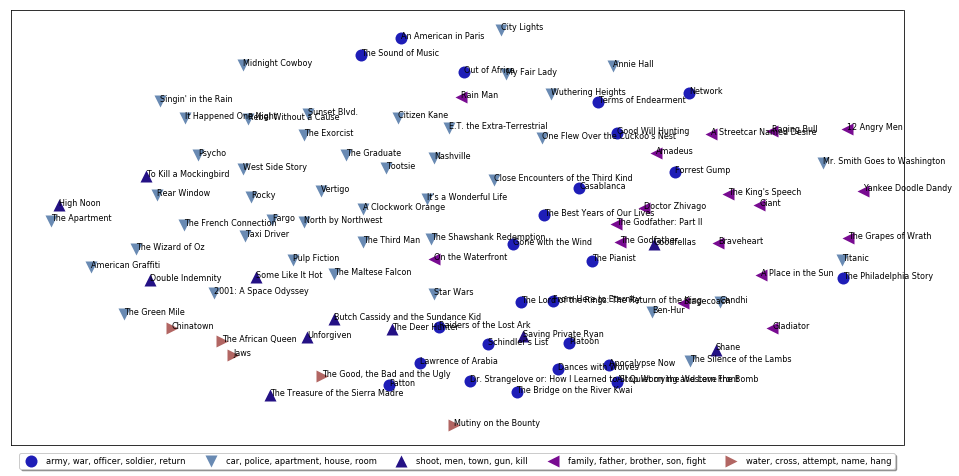

In [9]:
# visualize the clusters
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8)) 

# AFFINITY PROPAGATION

The AP algorithm iteratively proceeds by executing two message-passing steps as follows:

1. Responsibility updates are sent around, which can be mathematically represented as ![$$ r\left(i,\ k\right)\ \leftarrow sim\left(i,\ k\right) - \underset{k^{\prime}\ne\ k}{ \max}\left\{a\left(i,\ {k}^{\prime}\right)+sim\left(i,\ {k}^{\prime}\right)\right\} $$](https://learning.oreilly.com/library/view/text-analytics-with/9781484223871/A427287_1_En_6_Chapter_IEq22.gif)

   where the responsibility matrix is *R* and *r*(*i*, *k*) is a measure which quantifies how well *x* *k* can serve as being the representative or exemplar for *x* *i* in comparison to the other candidates.

2. Availability updates are then sent around which can be mathematically represented as ![$$ a\left(i,\ k\right)\ \leftarrow \min \left(0,\ r\left(k,\ k\right)+{\displaystyle \sum_{i^{\prime }\ \notin\ \left\{i,\ k\right\}}} \max \left(0,\ r\left({i}^{\prime },\ k\right)\right)\right) $$](https://learning.oreilly.com/library/view/text-analytics-with/9781484223871/A427287_1_En_6_Chapter_IEq23.gif) for *i* ≠ *k* and availability for ![$$ i=k $$](https://learning.oreilly.com/library/view/text-analytics-with/9781484223871/A427287_1_En_6_Chapter_IEq24.gif) is represented as![$$ a\left(k,\ k\right)\leftarrow\ {\displaystyle \sum_{i^{\prime }\ \ne k}} \max \Big(0,\ r\left({i}^{\prime },\ k\Big)\right) $$](https://learning.oreilly.com/library/view/text-analytics-with/9781484223871/A427287_1_En_6_Chapter_IEq25.gif)

   where the availability matrix is *A* and *a*(*i*, *k*) represents how appropriate it would be for *x* *i* to pick *x* *k*as its exemplar, considering all the other points’ preference to pick *x* *k* as an exemplar.

In [10]:
from sklearn.cluster import AffinityPropagation
              
def affinity_propagation(feature_matrix):
    
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_          
    return ap, clusters

In [11]:
# get clusters using affinity propagation
ap_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)
movie_data['Cluster'] = clusters

In [12]:
# get the total number of movies per cluster
c = Counter(clusters)   
print (c.items()  )

dict_items([(0, 5), (2, 12), (6, 10), (11, 4), (1, 6), (16, 7), (3, 6), (13, 7), (5, 7), (8, 4), (9, 8), (12, 5), (4, 2), (7, 7), (14, 4), (15, 3), (10, 3)])


In [13]:
# get total clusters
total_clusters = len(c)
print ('Total Clusters:', total_clusters)

Total Clusters: 17


In [15]:
# get clustering analysis data
cluster_data =  get_cluster_data(clustering_obj=ap_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=total_clusters,
                                 topn_features=5) 

In [16]:
# print clustering analysis results
print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ['able', 'always', 'cover', 'end', 'charge']
Movies in this cluster:
The Godfather, The Godfather: Part II, Doctor Zhivago, The Pianist, Goodfellas
Cluster 1 details:
--------------------
Key features: ['alive', 'accept', 'around', 'agree', 'attack']
Movies in this cluster:
Casablanca, One Flew Over the Cuckoo's Nest, Titanic, 2001: A Space Odyssey, The Silence of the Lambs, Good Will Hunting
Cluster 2 details:
--------------------
Key features: ['apartment', 'film', 'final', 'fall', 'due']
Movies in this cluster:
The Shawshank Redemption, Vertigo, West Side Story, Rocky, Tootsie, Nashville, The Graduate, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Rear Window, The Third Man
Cluster 3 details:
--------------------
Key features: ['arrest', 'film', 'evening', 'final', 'fall']
Movies in this cluster:
The Wizard of Oz, Psycho, E.T. the Extra-Terrestrial, My Fair Lady, Ben-Hur, Close Encounters of the Third Kind
Cluster 4 detail

/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:61: DeprecationWarning: 
.ix is deprecated. 

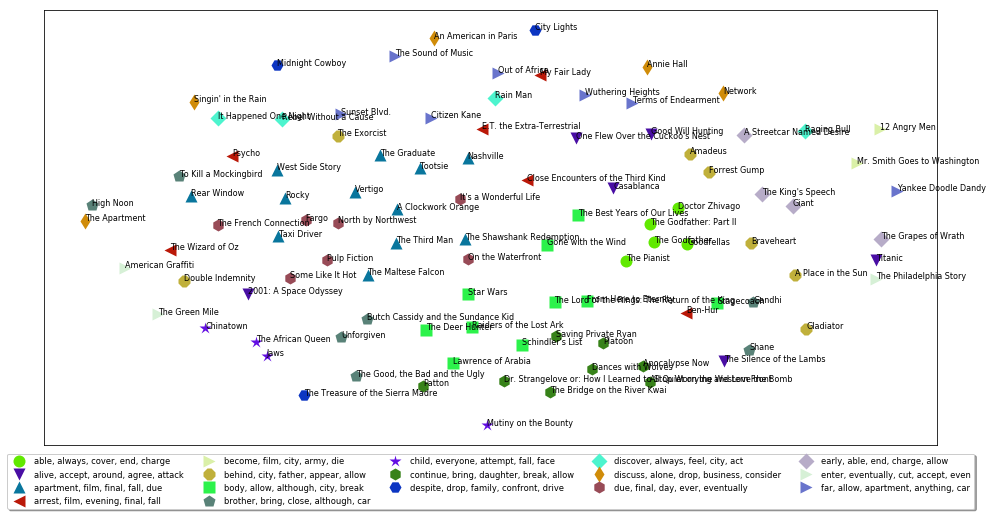

In [17]:
# visualize the clusters
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8)) 

# WARD’S AGGLOMERATIVE HIERARCHICAL CLUSTERING

There are two main strategies for Hierarchical clustering:

- *Agglomerative*: These algorithms follow a bottom-up approach where initially all data points belong to their own individual cluster, and then from this bottom layer, we start merging clusters together, building a hierarchy of clusters as we go up.
- *Divisive*: These algorithms follow a top-down approach where initially all the data points belong to a single huge cluster and then we start recursively dividing them up as we move down gradually, and this produces a hierarchy of clusters going from the top-down.

Figure [6-6](https://learning.oreilly.com/library/view/text-analytics-with/9781484223871/A427287_1_En_6_Chapter.html#Fig6) shows an example of how a dendrogram is constructed using agglomerative hierarchical clustering for a sample of documents.

![img](https://learning.oreilly.com/library/view/text-analytics-with/9781484223871/A427287_1_En_6_Fig6_HTML.jpg)

###### Figure 6-6. Agglomerative hierarchical clustering representation

In agglomerative clustering, for deciding which clusters we should combine when starting from the individual data point clusters, we need two things:

- *A* *distance metric*to measure the similarity or dissimilarity degree between data points. We will be using the Cosine distance/similarity in our implementation.
- *A* *linkage criterion*that determines the metric to be used for the merging strategy of clusters. We will be using Ward’s method here.

In [18]:
from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

In [19]:
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['Title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=200)

In [20]:
# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)

/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


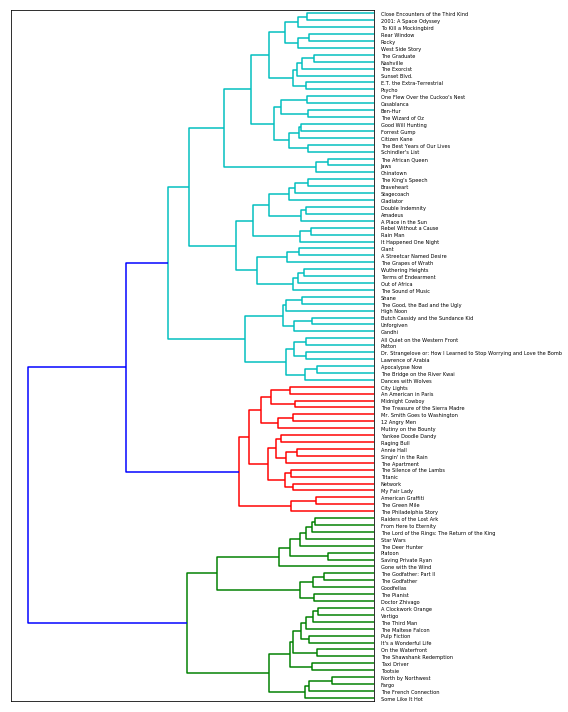

In [21]:
# plot the dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=movie_data,
                           figure_size=(8,10))